In [ ]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from solve_yw import YullieWalker
from datetime import datetime
import scipy

In [ ]:
data_path = "../../datasets/eyetracking/Eye-tracking-Kaggle"
fnames = glob.glob(data_path + "/*.csv")
print("found {} files".format(len(fnames)))

In [ ]:
data = pd.read_csv(fnames[1], low_memory=False)
data.head(5)

In [ ]:
participants = data['Participant'].unique()
print(participants)

In [ ]:
columns = data.columns
data = data.replace('-', np.nan)

In [ ]:
columns2parse = ['Pupil Diameter Left [mm]', 'Pupil Diameter Right [mm]', 'Gaze Vector Right Y', 'Gaze Vector Right X',
     'Gaze Vector Left Y', 'Gaze Vector Left X']
for c in columns2parse:
    data[c] = pd.to_numeric(data[c].replace('-', np.nan))
data[data['Participant']=='43']['Pupil Diameter Left [mm]']

In [ ]:
fig, ax = plt.subplots(2, figsize=(10, 8))
ax[0].plot(data[data['Participant']=='50']['Pupil Diameter Left [mm]'])
ax[1].plot(data[data['Participant']=='50']['Pupil Diameter Right [mm]'])
plt.show()

In [ ]:
def time_to_seconds(time_str):
    # Convert time string to datetime object
    time_obj = datetime.strptime(time_str, "%H:%M:%S:%f")

    # Calculate total seconds
    total_seconds = (time_obj.hour * 3600 + time_obj.minute * 60 + time_obj.second +
                     time_obj.microsecond / 1e6)

    return total_seconds

In [ ]:
corrs = []
for p in participants:
    left = data[data['Participant']==p]['Pupil Diameter Left [mm]'].dropna().to_numpy()
    right = data[data['Participant']==p]['Pupil Diameter Right [mm]'].dropna().to_numpy()
    corrs.append(scipy.stats.pearsonr(left, right)[0])
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(corrs, participants, '.')
ax.set_xlabel("pearson correlation")
ax.set_ylabel("participant")
ax.grid(True)
plt.show()

In [ ]:
left = data[data['Participant']=='47']['Pupil Diameter Left [mm]'].dropna().to_numpy()
right = data[data['Participant']=='47']['Pupil Diameter Right [mm]'].dropna().to_numpy()
t_ax = t = np.array([time_to_seconds(t) for t in data[data['Participant']=='47']["Time of Day [h:m:s:ms]"].dropna()])[1:]
t_ax = t_ax-t_ax[0]
t_ax = t_ax[:left.shape[-1]]

In [ ]:
YW = YullieWalker()

In [ ]:
left_est, theta_left = YW.est_ar_params(left, win_len=4, step=1)
right_est, theta_right = YW.est_ar_params(right, win_len=4, step=1)
print(t_ax.shape, left.shape, left_est.shape)
err_l = left-left_est
err_r = right-right_est
print(theta_left)
print(theta_right)
print(err_l.std(), theta_right.std())

In [ ]:
blinks_l = (np.abs(left-left_est) > err_l.std() * 3) & (err_l < 0)
blinks_r = (np.abs(right-right_est) > err_r.std() * 3) & (err_r < 0)

In [ ]:
fig, ax = plt.subplots(2, figsize=(10, 8))
ax[0].plot(t_ax, left)
ax[0].plot(t_ax, left_est)
ax[0].plot(t_ax[blinks_l], left[blinks_l], 'ro')
ax[0].grid(True)
ax[0].set_ylabel("left")
ax[1].plot(t_ax, right)
ax[1].plot(t_ax, right_est)
ax[1].plot(t_ax[blinks_r], right[blinks_r], 'ro')
ax[1].grid(True)
ax[1].set_ylabel("right")
plt.show()

In [ ]:
L = np.fft.rfft(left)
L_est = np.fft.rfft(left_est)
R = np.fft.rfft(right)
R_est = np.fft.rfft(right_est)
n_fft = left.shape[-1]
fs = float(np.ceil(1/np.median(np.diff(t_ax))))
print("{}".format(fs))
f_ax = np.arange(0, fs/2, fs/n_fft)
if f_ax.shape[-1] != R.shape[-1]:
    f_ax = np.arange(0, fs/2+fs/n_fft, fs/n_fft)
fig, ax = plt.subplots(2)
ax[0].plot(f_ax, 10*np.log10(np.abs(L)/np.max(np.abs(L))))
ax[0].plot(f_ax, 10*np.log10(np.abs(L_est)/np.max(np.abs(L_est))))
ax[0].grid(True)

ax[1].plot(f_ax, 10*np.log10(np.abs(R)/np.max(np.abs(R))))
ax[1].plot(f_ax, 10*np.log10(np.abs(R_est)/np.max(np.abs(R_est))))
ax[1].grid(True)

# Rendering of Eyes for Eye-Shape Registration and Gaze Estimation
https://www.cl.cam.ac.uk/research/rainbow/projects/syntheseyes/
syntheseyes_data

## The associated data for each image is a dict with keys:
    look_vec – the 3D gaze direction in camera space.
    head_pose – a 3x3 matrix rotation from world space to camera space.
    ldmks – a dict containing the following 2D and 3D landmarks:
    ldmks_lids_2d, ldmks_iris_2d, ldmks_pupil_2d in screen space.
    ldmks_lids_3d, ldmks_iris_3d, ldmks_pupil_3d in camera space

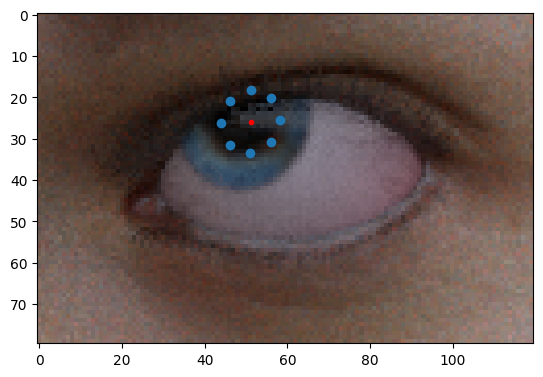

In [20]:
import glob
import numpy as np
import pickle
from PIL import Image
import cv2
import matplotlib.pyplot as plt
data_path = r"../../datasets/eyetracking/syntheseyes_data"
fnames = glob.glob(data_path + "/**/**/*.pkl")
with open(fnames[0], "rb") as f:
    data = pickle.load(f)
img = cv2.imread(fnames[0][:-4] + ".png")[:, :, ::-1]
lmks = np.array(data['ldmks']['ldmks_pupil_2d'])
plt.imshow(img)
plt.plot(lmks[:, 0], lmks[:, 1], 'o')
plt.plot(lmks[:, 0].mean(), lmks[:, 1].mean(), 'r.')
plt.show()